<h1>Automated Gating with Immunova: Creating a template for PDMC samples</h1>

In [1]:
from immunova.data.project import Project
from immunova.data.mongo_setup import global_init
from immunova.flow.gating.actions import Template
from tqdm import tqdm_notebook, tqdm
from functools import partial
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
global_init()

In [2]:
peritonitis = Project.objects(project_id='Peritonitis').get()

<h2>T Panel Template</h2>

In [3]:
peritonitis.list_fcs_experiments()

['PBMC_T', 'PDMC_T', 'PBMC_M', 'PDMC_M']

In [4]:
pdmc_t = peritonitis.load_experiment('PDMC_T')

In [5]:
t_template = Template(experiment=pdmc_t, sample_id='pd318-01_t')

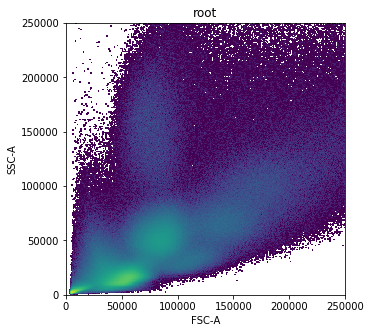

In [6]:
_ = t_template.plot_population('root', x='FSC-A', y='SSC-A')

<h3>Boundary gate</h3>

In [7]:
kwargs=dict(x_min=10000, x_max=125000, y_min=0, y_max=70000)
t_template.create_gate(gate_name='boundary_gate', children=['cells'], parent='root', x='FSC-A',
                      y='SSC-A', func='rect_gate', func_args=kwargs, gate_type='geom')

True

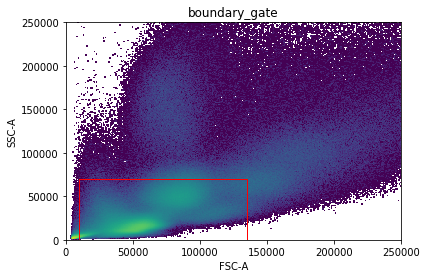

In [8]:
t_template.apply('boundary_gate')

<h3>Lymphocyte gate</h3>

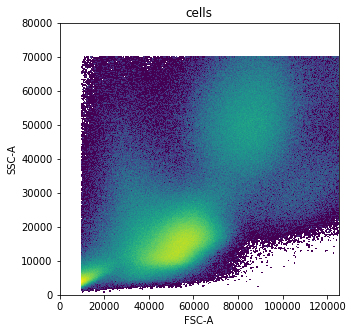

In [9]:
_ = t_template.plot_population('cells', x='FSC-A', y='SSC-A', xlim=(0,125000), ylim=(0,80000))

In [10]:
kwargs=dict(target=(50000,15000), k=4)
t_template.create_gate(gate_name='lymphocyte_gate', children=['lymphocytes'], parent='cells', x='FSC-A',
                      y='SSC-A', func='mm_gate', func_args=kwargs, gate_type='geom')

True

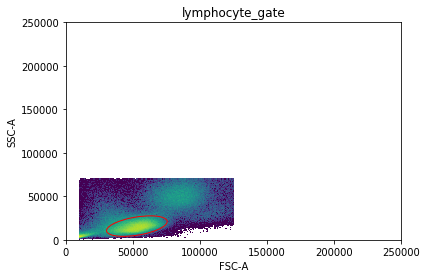

In [11]:
t_template.apply('lymphocyte_gate')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f17c4911a58>)

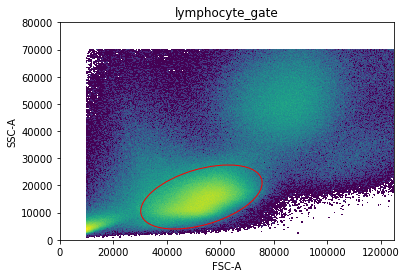

In [12]:
t_template.plot_gate('lymphocyte_gate', xlim=(0,125000), ylim=(0,80000))

<h3>Singlet gate</h3>

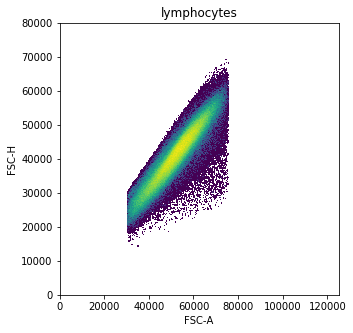

In [13]:
_ = t_template.plot_population('lymphocytes', x='FSC-A', y='FSC-H', xlim=(0,125000), ylim=(0,80000))

In [14]:
kwargs=dict(target=(60000,40000), k=2, conf=0.99)
t_template.create_gate(gate_name='singlet_gate', children=['singlets'], parent='lymphocytes', x='FSC-A',
                      y='FSC-H', func='mm_gate', func_args=kwargs, gate_type='geom')

True

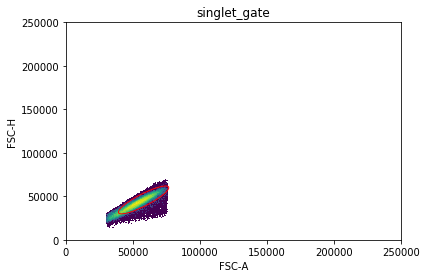

In [15]:
t_template.apply('singlet_gate')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f17c30c40b8>)

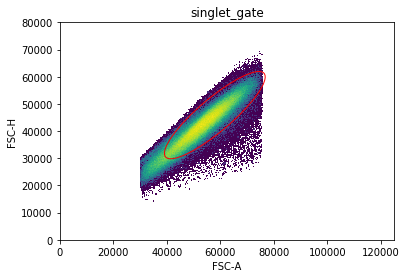

In [16]:
t_template.plot_gate('singlet_gate', xlim=(0,125000), ylim=(0,80000))

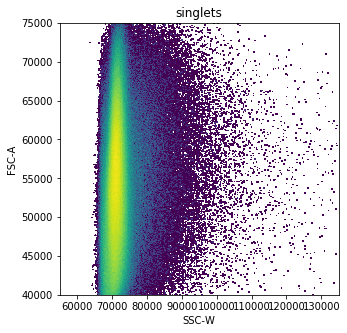

In [17]:
_ = t_template.plot_population('singlets', x='SSC-W', y='FSC-A', xlim=(55000,135000), ylim=(40000,75000))

In [18]:
kwargs=dict(q=0.95)
t_template.create_gate(gate_name='singlet_gate_2', children=['singlets2'], parent='singlets', x='SSC-W',
                       func='quantile_gate', func_args=kwargs, gate_type='geom')

True

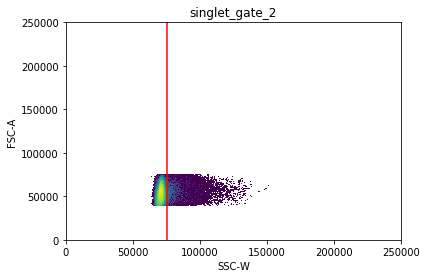

In [19]:
t_template.apply('singlet_gate_2')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f17d5b0c978>)

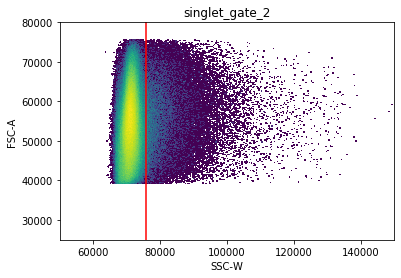

In [20]:
t_template.plot_gate('singlet_gate_2', xlim=(50000,150000), ylim=(25000, 80000))

<h3>Live/Dead Gate</h3>

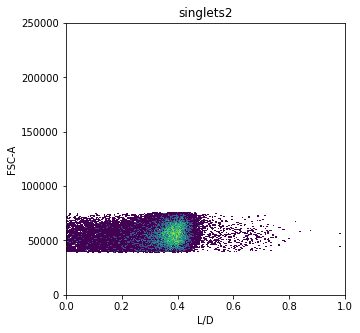

In [21]:
_ = t_template.plot_population('singlets2', x='L/D', y='FSC-A')

In [22]:
kwargs=dict(q=0.99, bool_gate=True, kde_bw=0.1, kde_sample_frac=0.5, ignore_double_pos=True, 
            peak_threshold=0.05)
t_template.create_gate(gate_name='livedead_gate', children=['live'], parent='singlets2', x='L/D',
                       func='density_gate_1d', func_args=kwargs, gate_type='geom')

True

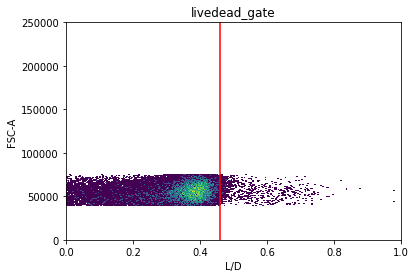

In [23]:
t_template.apply('livedead_gate')

<h3>T Cells (CD3+)</h3>

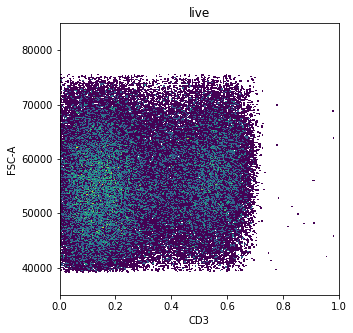

In [24]:
_ = t_template.plot_population('live', x='CD3', y='FSC-A', ylim=(35000,85000))

In [25]:
kwargs=dict(q=0.95, kde_bw=0.1, kde_sample_frac=1, ignore_double_pos=True, 
            peak_threshold=0.05)
t_template.create_gate(gate_name='cd3_gate', children=['cd3+'], parent='live', x='CD3',
                       func='density_gate_1d', func_args=kwargs, gate_type='geom')

True

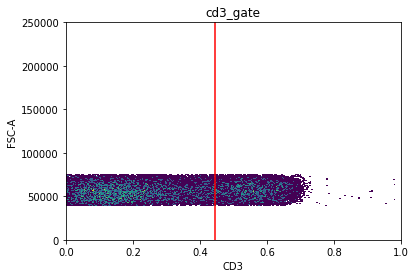

In [26]:
t_template.apply('cd3_gate')

<h3>Gamma Delta T cells</h3>

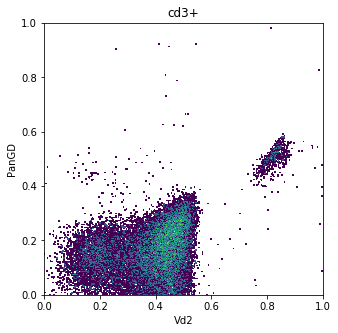

In [27]:
_ = t_template.plot_population('cd3+', x='Vd2', y='PanGD')

In [28]:
kwargs=dict(min_pop_size=10, distance_nn=0.05, expected_populations=[{'id': 'gdt', 'target': (0.9, 0.6)},
                                                                   {'id': 'vd2-', 'target': (0.2, 0.6)},
                                                                   {'id': 'non_gdt', 'target': (0.3, 0.1)}],
            core_only=False)
t_template.create_gate(gate_name='gdt_gate', children=['gdt', 'vd2-', 'non_gdt'], parent='cd3+', x='Vd2',
                       y='PanGD', func='dbscan_gate', func_args=kwargs, gate_type='cluster')

True

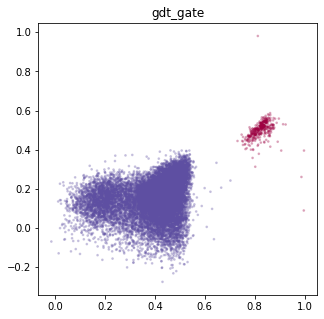

In [29]:
t_template.apply('gdt_gate')

<h3>MAITs</h3>

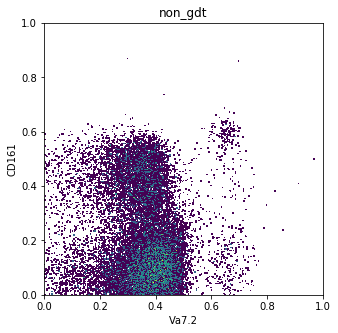

In [30]:
_ = t_template.plot_population('non_gdt', x='Va7.2', y='CD161')

In [31]:
kwargs=dict(min_pop_size=10, distance_nn=0.05, expected_populations=[{'id': 'mait', 'target': (0.8, 0.6)},
                                                                   {'id': 'classic_tcells', 'target': (0.3, 0.3)}],
            core_only=False, nn=10, sample=0.3)
t_template.create_gate(gate_name='mait_gate', children=['mait', 'classic_tcells'], parent='non_gdt', x='Va7.2',
                       y='CD161', func='dbscan_gate', func_args=kwargs, gate_type='cluster')

True

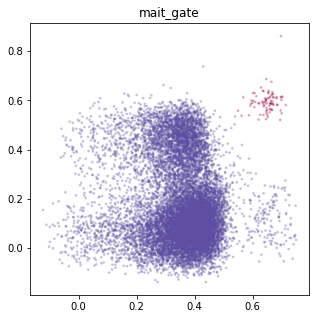

In [32]:
t_template.apply('mait_gate')

<h3>Classic T cells</h3>

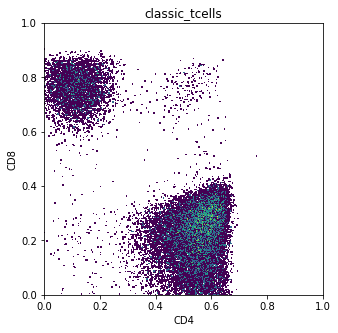

In [33]:
_ = t_template.plot_population('classic_tcells', x='CD4', y='CD8')

In [34]:
kwargs=dict(min_pop_size=100, distance_nn=0.05, expected_populations=[{'id': 'cd4', 'target': (0.8, 0.3)},
                                                                      {'id': 'cd8', 'target': (0.1, 0.8)}],
            core_only=False, nn=10, sample=0.3)
t_template.create_gate(gate_name='cd4cd8_gate', children=['cd4', 'cd8'], parent='classic_tcells', 
                       x='CD4',y='CD8', func='dbscan_gate', func_args=kwargs, gate_type='cluster')

True

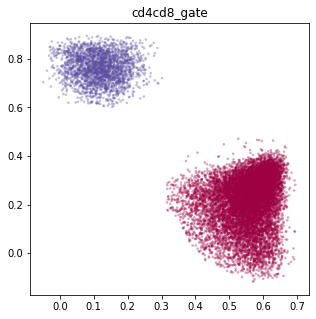

In [35]:
t_template.apply('cd4cd8_gate')

<h2>FMO Gating</h2>

In [36]:
t_template.fmo.keys()

dict_keys(['pd318-01_t_CXCR3', 'pd318-01_t_CD27', 'pd318-01_t_CD45RA', 'pd318-01_t_CCR7'])

<h3>GDTs</h3>

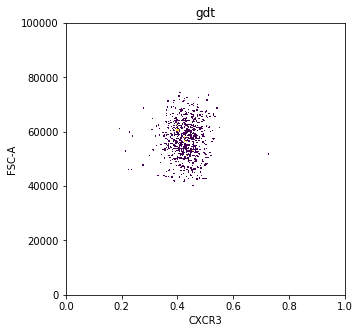

In [40]:
_ = t_template.plot_population('gdt', x='CXCR3', y='FSC-A', ylim=(0,100000))

In [ ]:
kwargs = dict(fmo_x='CXCR3', kde_bw=0.01, kde_frac=0.5, q=0.99, peak_t=0.01, fmo_z=2)
t_template.create_gate(gate_name='gdt_cxcr3', children=['gdt_cxcr3+'], parent='classic_tcells', 
                       x='CD4',y='CD8', func='dbscan_gate', func_args=kwargs, gate_type='cluster')